In [1]:
%matplotlib inline
import numpy as np
import nengo
import nengolib
from nengolib.signal import s
from nengolib.synapses import Lowpass
from nengo_bioneurons import BahlNeuron, build_filter
import matplotlib.pyplot as plt
from seaborn import kdeplot
from nengo.utils.matplotlib import rasterplot
from pathos import multiprocessing as mp
from pickle import PicklingError
import copy

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [8]:
def evolve_h_d_out(
    network,
    ss,
    tau,
    t_evo,
    n_threads,
    evo_popsize,
    evo_gen,
    es,
    reg_init,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    reg_delta,
    p_act,
    p_target,
    verbose=False):
    
    import nengolib

    def evaluate(inputs):
        network = inputs[0]
        zeros = inputs[1]
        poles = inputs[2]
        reg = inputs[3]
        p_act = inputs[4]
        p_target = inputs[5]
        d_return = inputs[6]
        
        """ run the simulation, collect filtered activites, apply oracle method to calculate readout decoders """
        with nengo.Simulator(network, progress_bar=verbose, seed=ss) as sim:
            sim.run(t_evo)
        h_out = build_filter(zeros, poles)
        act_f = h_out.filt(sim.data[p_act])
        target_f = nengo.Lowpass(tau).filt(sim.data[p_target])
#         target_f = h_out.filt(sim.data[p_target])
        
        if np.sum(act_f) > 0:
            d, _ = nengo.solvers.LstsqL2(reg=reg)(act_f, target_f)
        else:
            d = np.zeros((act_f.shape[1], target_f.shape[1]))
        xhat = np.dot(act_f, d)
        e = nengolib.signal.nrmse(xhat, target=target_f)
        if not d_return:
            return e
        else:
            return e, d

    pool = mp.ProcessingPool(nodes=n_threads)
    rng = np.random.RandomState(seed=es)

    """ Initialize evolutionary population """
    zeros_pop = []
    poles_pop = []
    reg_pop = []
    for p in range(evo_popsize):
        my_zeros = [rng.uniform(-z, z) for z in zeros_init]
        my_poles = [rng.uniform(0, p) for p in poles_init]  # poles must be negative
        my_reg = np.abs(rng.normal(reg_init, reg_delta))
        zeros_pop.append(my_zeros)
        poles_pop.append(my_poles)
        reg_pop.append(my_reg)


    """ Run evolutionary strategy """
    fit_vs_gen = []
    for g in range(evo_gen):
        # reconfigure nengolib synapses to have propper attributes to be passed to pool.map()
        # these synapses are restored to the evolved filter inside evaluate()
        for probe in network.probes:
            if isinstance(probe.synapse, nengolib.signal.LinearSystem):
                try:
                    probe.synapse._paramdict = nengo.Lowpass(tau)._paramdict
                    probe.synapse.tau = tau
                    probe.synapse.default_size_in = 1
                    probe.synapse.default_size_out = 1
                except:
                    continue
        for conn in network.connections:
            if isinstance(conn.synapse, nengolib.signal.LinearSystem):
                try:
                    conn.synapse._paramdict = nengo.Lowpass(tau)._paramdict
                    conn.synapse.tau = tau
                    conn.synapse.default_size_in = 1
                    conn.synapse.default_size_out = 1
                except:
                    continue
        inputs = [[network, zeros_pop[p], poles_pop[p], reg_pop[p], p_act, p_target, False] \
                  for p in range(evo_popsize)]
        try:
            fitnesses = np.array(pool.map(evaluate, inputs))
        except PicklingError:
            fitnesses = np.array([evaluate(inpt) for inpt in inputs])  # debugging/jupyter
        best_zeros = zeros_pop[np.argmin(fitnesses)]
        best_poles = poles_pop[np.argmin(fitnesses)]
        best_reg = reg_pop[np.argmin(fitnesses)]
        best_fitness = fitnesses[np.argmin(fitnesses)]
        fit_vs_gen.append([best_fitness])
        decay = np.exp(-g / 5.0)

        """ repopulate filter pops with mutated copies of the best individual """
        zeros_pop_new = []
        poles_pop_new = []
        reg_pop_new = []
        for p in range(evo_popsize):
            my_zeros = [rng.normal(z, zeros_delta[term]*decay) for term, z in enumerate(best_zeros)]
            my_poles = [rng.normal(p, poles_delta[term]*decay) for term, p in enumerate(best_poles)]
            my_reg = np.abs(rng.normal(best_reg, reg_delta*decay))
            zeros_pop_new.append(my_zeros)
            poles_pop_new.append(my_poles)
            reg_pop_new.append(my_reg)
        zeros_pop = zeros_pop_new
        poles_pop = poles_pop_new
        reg_pop = reg_pop_new

    """ Compute final decoders using the evolved filters and regularization """
    best_d = evaluate([network, best_zeros, best_poles, best_reg, p_act, p_target, True])
    
    if verbose:
        plt.figure()
        plt.plot(np.arange(0, evo_gen), np.array(fit_vs_gen))
        plt.xlabel('generation')
        plt.ylabel('fitness')
        plt.show()

        plt.figure()
        times = np.arange(0, 1e0, 1e-3)
        plt.plot(times, build_filter(best_zeros, best_poles).impulse(len(times)), label='evolved')
        plt.plot(times, nengolib.Lowpass(tau).impulse(len(times)), label='lowpass')
        plt.xlabel('time')
        plt.ylabel('amplitude')
        plt.legend()
        plt.show()
        
    del pool

    return best_zeros, best_poles, best_reg, best_d

In [11]:
def train(transition=[0, 1],
       es=0,
       cs=1,
       ss=2,
       n=100,
       tau=0.1,
       freq=5*np.pi,
       t=1,
       n_pre2=100,
       tau_pre2=0.01,
       n_syn=1,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       solver=nengo.solvers.LstsqL2(reg=1.0),
       t_evo=1.0,
       n_threads=1,
       evo_popsize=10,
       evo_gen=5,
       zeros_init=[],
       poles_init=[-1e2, -1e2],
       reg_init=1.0,
       zeros_delta=[],
       poles_delta=[1e1, 1e1],
       reg_delta=1e-2,
       verbose=False,
       cmap="winter"):
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now evolve decoders and readout filters for "inter", which will be used on the inter_bio connection
    # target is filtered once by the tau required for the integrator, then again for the pre2_inter synapse
    with nengo.Network() as network:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        nengo.Connection(pre2, inter,
                         sec='apical',
                         n_syn=n_syn,
                         syn_type='ExpSyn',
                         tau_list=[tau_pre2],
                         synapse=tau_pre2,
                         transform=1.0/norm_f2f,
                         seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        network.p_act = nengo.Probe(inter.neurons, synapse=None)
        network.p_target = nengo.Probe(tar, synapse=None)
        
    z_inter, p_inter, reg_inter, d_inter_evo = evolve_h_d_out(
        network,
        ss,
        tau,
        t_evo,
        n_threads,
        evo_popsize,
        evo_gen,
        es,
        reg_init,
        zeros_init,
        poles_init,
        zeros_delta,
        poles_delta,
        reg_delta,
        network.p_act,
        network.p_target,
        verbose)
    h_out = build_filter(z_inter, p_inter)

    with nengo.Simulator(network, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    act_f = h_out.filt(sim.data[network.p_act])
    target_f2f = h_out.filt(lpf2.filt(sim.data[network.p_target]))
    d_inter, _ = nengo.solvers.LstsqL2(reg=reg_inter)(act_f, target_f2f)
    xhat_inter = np.dot(act_f, d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target_f2f)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()
            
    # now take the network through the transition,
    # evolving new for the readout/recurrent decoders/filters for bio at each point
    d_bio = d_inter
    h_out_inter = h_out
    tau_rise_bio = 1.0 / p_inter[0]
    tau_fall_bio = 1.0 / p_inter[1]
    tau_rise_inter = 1.0 / p_inter[0]
    tau_fall_inter = 1.0 / p_inter[1]
    z_bio = z_inter
    p_bio = p_inter
    reg_bio = reg_inter
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
    
    for i, p in enumerate(transition):
        with nengo.Network() as network:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='Exp2Syn',
                             tau_list=[tau_rise_bio, tau_fall_bio],
                             synapse=h_out,
                             transform=tau/norm_f,
                             seed=cs)
            nengo.Connection(stim, pre2, synapse=1/s)
            nengo.Connection(pre2, inter,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau_pre2],
                             synapse=tau_pre2,
                             transform=1.0/norm_f,
                             seed=cs)
            nengo.Connection(bio, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='Exp2Syn',
                             tau_list=[tau_rise_bio, tau_fall_bio],
                             synapse=h_out,
                             transform=p,
                             solver=nengo.solvers.NoSolver(d_bio),
                             seed=cs)
            nengo.Connection(inter, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='Exp2Syn',
                             tau_list=[tau_rise_inter, tau_fall_inter],
                             synapse=h_out_inter,
                             transform=1-p,
                             solver=nengo.solvers.NoSolver(d_inter),
                             seed=cs)
            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            network.p_act = nengo.Probe(bio.neurons, synapse=None)
            network.p_inter = nengo.Probe(inter, synapse=h_out_inter, solver=nengo.solvers.NoSolver(d_inter))
            network.p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_bio))
            network.p_target = nengo.Probe(tar, synapse=None)
             
        z_bio, p_bio, reg_bio, d_bio_evo = evolve_h_d_out(
            network,
            ss,
            tau,
            t_evo,
            n_threads,
            evo_popsize,
            evo_gen,
            es,
            reg_bio,
            z_bio,
            p_bio,
            zeros_delta,
            poles_delta,
            reg_delta,
            network.p_act,
            network.p_target,
            verbose)
        h_out = build_filter(z_bio, p_bio)

        with nengo.Simulator(network, progress_bar=verbose) as sim:
            sim.run(t, progress_bar=verbose)

        act_f = h_out.filt(sim.data[network.p_act])
        target_f2f = h_out.filt(lpf2.filt(sim.data[network.p_target]))
        d_bio_new, _ = nengo.solvers.LstsqL2(reg=reg_bio)(act_f, target_f2f)
        xhat_bio = np.dot(act_f, d_bio)
        e_bio = nengolib.signal.nrmse(xhat_bio, target=target_f2f)

        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(d_bio_new - d_bio)
            scatter_c.extend([i]*n)
            scatter_e.append(e_bio)
            
        d_bio = d_bio_new
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e_bio))
            plt.plot(sim.trange(), target_f2f, label=r"$x_f$", linestyle='--')
            plt.plot(sim.trange(), sim.data[network.p_inter], label=r"$\hat{x}_{inter}$", linestyle='-.')
            plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
            plt.legend()
            plt.show()
#             plt.figure()
#             plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
#             plt.plot(sim.trange(), act_f, label=r"$a$", linestyle='-')
#             plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()
    
    return d_inter, d_bio, z_bio, p_bio

In [12]:
def test(d_bio,
       signal='cos',
       es=0,
       cs=1,
       ss=2,
       n=100,
       tau=0.1,
       tau_rise=0.01,
       tau_fall=0.1,
       freq=5,
       t=1,
       n_syn=1,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       h_out=nengo.Lowpass(0.1),
       sec='apical',
       verbose=False):
    
    # first find the norm of the filtered signal
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
        
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
        
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = h_out.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    # now run the full simulations with the appropriate normalizing transforms
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        nengo.Connection(stim, pre, synapse=None)
        nengo.Connection(pre, bio,
                         sec=sec,
                         n_syn=n_syn,
                         syn_type='Exp2Syn',
                         tau_list=[tau_rise, tau_fall],
                         synapse=h_out,
                         transform=tau/norm_f,
                         seed=cs)
        nengo.Connection(bio, bio,
                         sec=sec,
                         n_syn=n_syn,
                         syn_type='Exp2Syn',
                         tau_list=[tau_rise, tau_fall],
                         synapse=h_out,
                         solver=nengo.solvers.NoSolver(d_bio),
                         seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)

#         p_act = nengo.Probe(bio.neurons, synapse=None)
        p_target = nengo.Probe(tar, synapse=h_out)
        p_bio = nengo.Probe(bio, synapse=h_out, solver=nengo.solvers.NoSolver(d_bio))

    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    target = sim.data[p_target]
    xhat_bio = sim.data[p_bio]
    e = nengolib.signal.nrmse(xhat_bio, target=target)
    
    plt.figure()
    plt.title(r"NRMSE=%.3f" % (e))
    plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
    plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
    plt.legend()
    plt.show()

### ALIF testing

In [ ]:
d_inter, d_bio, z_bio, p_bio = train(evo_gen=3, verbose=True, reg_init=1.0, reg_delta=0.025)

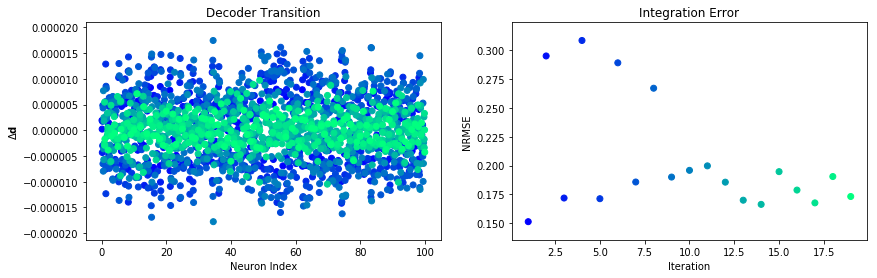

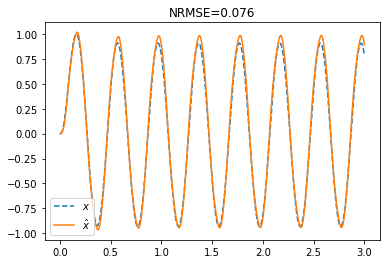

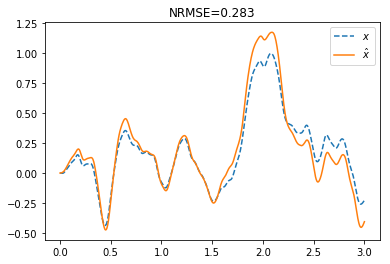

In [16]:
d_inter, d_bio, z_bio, p_bio = train(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    evo_gen=10,
    freq=5*np.pi,
    verbose=False,
    reg_init=1.0,
    reg_delta=0.03)

test(d_bio,
     signal='cos',
     tau_rise=1.0/p_bio[0],
     tau_fall=1.0/p_bio[1],
     freq=5*np.pi,
     t=3,
     h_out=build_filter(z_bio, p_bio))

test(d_bio,
     signal='white_noise',
     tau_rise=1.0/p_bio[0],
     tau_fall=1.0/p_bio[1],
     freq=5*np.pi,
     t=3,
     h_out=build_filter(z_bio, p_bio))

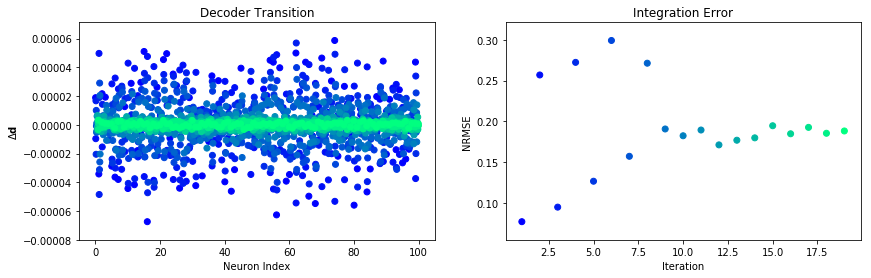

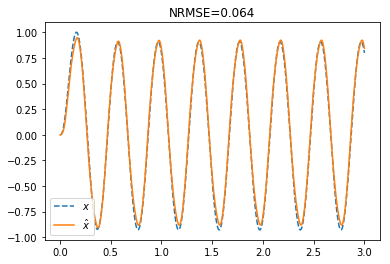

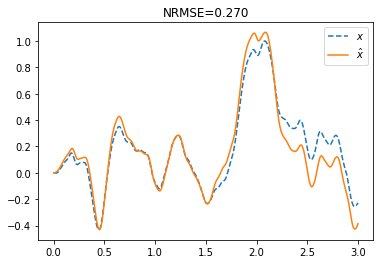

In [17]:
d_inter, d_bio, z_bio, p_bio = train(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    evo_gen=10,
    freq=5*np.pi,
    verbose=False,
    reg_init=0.2,
    reg_delta=0.02)

test(d_bio,
     signal='cos',
     tau_rise=1.0/p_bio[0],
     tau_fall=1.0/p_bio[1],
     freq=5*np.pi,
     t=3,
     h_out=build_filter(z_bio, p_bio))

test(d_bio,
     signal='white_noise',
     tau_rise=1.0/p_bio[0],
     tau_fall=1.0/p_bio[1],
     freq=5*np.pi,
     t=3,
     h_out=build_filter(z_bio, p_bio))

## Bioneurons

In [ ]:
d_inter, d_bio, h_out = train(
    neuron_type=BahlNeuron(),
    evo_gen=4,
    verbose=True,
    reg_init=0.5,
    reg_delta=0.01,
    poles_delta=[2e0, 2e0])

In [ ]:
d_inter, d_bio, h_out = train(
    transition=[0, 0.5, 1.0, 1.0],
    neuron_type=BahlNeuron(),
    evo_gen=5,
    verbose=True,
    reg_init=0.2,
    reg_delta=0.02,
    poles_delta=[3e0, 3e0])